In [1]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
import gseapy as gp
import seaborn as sns

from tqdm import tqdm
from scripts import constants

In [2]:
dataset = "zheng_2017"

In [3]:
adata = sc.read_h5ad(
    os.path.join(
        constants.DEFAULT_DATA_PATH,
        f"{dataset}/preprocessed/adata_top_2000_genes.h5ad",
    )
)

In [4]:
target_indices = np.where(adata.obs["condition"] != "healthy")[0]

In [5]:
genes = pd.read_table(
    os.path.join(
        "/projects/leelab/data/single-cell/zheng_2017",
        "aml027_post_transplant_filtered_gene_bc_matrices",
        "filtered_matrices_mex/hg19",
        "genes.tsv",
    ),
    header=None,
)
genes = genes.rename(columns={0: "ensembl_id", 1: "gene_symbol"})
genes = genes[genes["ensembl_id"].isin(adata.var.index)]

In [6]:
seeds = [123, 42, 789, 46, 999]
latent_size = 10
result_list = []

for seed in tqdm(seeds):
    background_expr = np.load(
        os.path.join(
            constants.DEFAULT_RESULTS_PATH,
            f"{dataset}/contrastiveVI/latent_{latent_size}/{seed}",
            "background_normalized_expression.npy",
        ),
    )
    salient_expr = np.load(
        os.path.join(
            constants.DEFAULT_RESULTS_PATH,
            f"{dataset}/contrastiveVI/latent_{latent_size}/{seed}",
            "salient_normalized_expression.npy",
        ),
    )
    background_expr = background_expr[target_indices, :]
    salient_expr = salient_expr[target_indices, :]
    
    expr_mag_change = np.abs(salient_expr - background_expr)
    expr_mag_logfc = np.abs(np.log2(salient_expr / background_expr))
    
    results = genes.copy()
    results["mag_change_mean"] = np.mean(expr_mag_change, axis=0)
    results["mag_change_median"] = np.median(expr_mag_change, axis=0)
    results["mag_logfc_mean"] = np.mean(expr_mag_logfc, axis=0)
    results["mag_logfc_median"] = np.median(expr_mag_logfc, axis=0)
    results["seed"] = seed
    result_list.append(results)

results = pd.concat(result_list)
results = results.drop(columns=["ensembl_id"])

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.48s/it]


In [7]:
result_means = results.groupby("gene_symbol", as_index=False).mean().drop(columns=["seed"])

In [8]:
metric_list = [
    "mag_change_mean",
    "mag_change_median",
    "mag_logfc_mean",
    "mag_logfc_median",
]

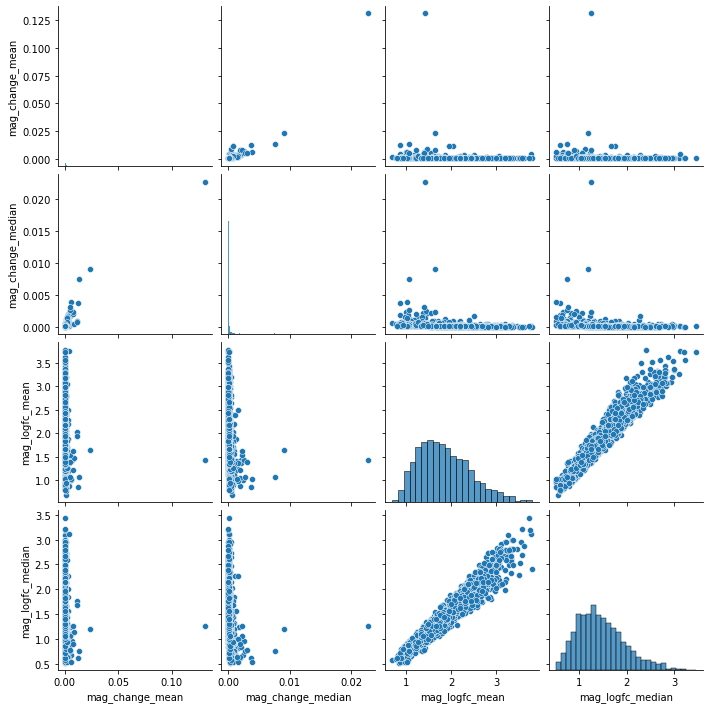

In [9]:
sns.pairplot(result_means[metric_list])

In [10]:
enr_result_dict = {}
top_gene_dict = {}
top_k = 100
cutoff = 0.2
for metric in metric_list:
    print(metric)
    sorted_genes = result_means.sort_values(by=metric, ascending=False)
    top_genes = sorted_genes.head(n=top_k)["gene_symbol"].tolist()
    enr = gp.enrichr(
        gene_list=top_genes,
        gene_sets="KEGG_2016",
        organism="human",
        cutoff=cutoff,
    )
    enr_results = enr.results
    enr_results = enr_results[enr_results["Adjusted P-value"] < cutoff]
    enr_results = enr_results.sort_values(by="Adjusted P-value")
    
    enr_result_dict[metric] = enr_results
    top_gene_dict[metric] = top_genes

mag_change_mean
mag_change_median


2021-11-17 17:07:05,329 Warning: No enrich terms using library KEGG_2016 when cutoff = 0.2


mag_logfc_mean
mag_logfc_median


In [11]:
enr_result_dict["mag_change_mean"]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2016,Hematopoietic cell lineage Homo sapiens hsa04640,4/88,0.000995,0.082557,0,0,9.829365,67.951406,HLA-DRB5;CD5;CD38;CD22
1,KEGG_2016,Staphylococcus aureus infection Homo sapiens h...,3/56,0.002774,0.115141,0,0,11.581599,68.184201,C1QA;HLA-DRB5;HLA-DPB1
2,KEGG_2016,Systemic lupus erythematosus Homo sapiens hsa0...,4/135,0.004722,0.124173,0,0,6.287850,33.674279,C1QA;HIST1H2BM;HLA-DRB5;HLA-DPB1
3,KEGG_2016,Antigen processing and presentation Homo sapie...,3/77,0.006789,0.124173,0,0,8.286152,41.368146,HLA-DRB5;CTSL;HLA-DPB1
4,KEGG_2016,Ribosome biogenesis in eukaryotes Homo sapiens...,3/89,0.010096,0.124173,0,0,7.125629,32.746408,SNORD3B-2;GAR1;PWP2
5,KEGG_2016,Rheumatoid arthritis Homo sapiens hsa05323,3/90,0.010407,0.124173,0,0,7.043370,32.154795,HLA-DRB5;CTSL;HLA-DPB1
6,KEGG_2016,Asthma Homo sapiens hsa05310,2/31,0.010472,0.124173,0,0,13.983814,63.752309,HLA-DRB5;HLA-DPB1
7,KEGG_2016,Allograft rejection Homo sapiens hsa05330,2/38,0.015478,0.160587,0,0,11.260771,46.938445,HLA-DRB5;HLA-DPB1
8,KEGG_2016,Graft-versus-host disease Homo sapiens hsa05332,2/41,0.017880,0.162379,0,0,10.392988,41.821870,HLA-DRB5;HLA-DPB1
9,KEGG_2016,Type I diabetes mellitus Homo sapiens hsa04940,2/43,0.019564,0.162379,0,0,9.885017,38.888399,HLA-DRB5;HLA-DPB1


In [12]:
enr_result_dict["mag_logfc_mean"]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2016,Alcoholism Homo sapiens hsa05034,6/179,0.000281,0.027750,0,0,7.278441,59.519162,GNG7;HIST1H2AE;GNAS;HIST1H3F;SLC29A1;CAMKK2
1,KEGG_2016,Cell cycle Homo sapiens hsa04110,5/124,0.000397,0.027750,0,0,8.748784,68.506222,CDC20;CDKN2D;CCNB1;CDKN1A;SKP2
2,KEGG_2016,FoxO signaling pathway Homo sapiens hsa04068,5/133,0.000548,0.027750,0,0,8.129934,61.054219,CDKN2D;CCNB1;CDKN1A;PRMT1;SKP2
3,KEGG_2016,Viral carcinogenesis Homo sapiens hsa05203,5/205,0.003692,0.140315,0,0,5.184211,29.039107,CDC20;CDKN1A;GSN;IRF7;SKP2
4,KEGG_2016,Systemic lupus erythematosus Homo sapiens hsa0...,4/135,0.004722,0.143559,0,0,6.287850,33.674279,HLA-DMB;SNRPD1;HIST1H2AE;HIST1H3F
5,KEGG_2016,Collecting duct acid secretion Homo sapiens hs...,2/27,0.008008,0.197737,0,0,16.224490,78.320495,CA2;ATP6V0E2
6,KEGG_2016,Galactose metabolism Homo sapiens hsa00052,2/30,0.009829,0.197737,0,0,14.483965,66.951564,GAA;PFKP
7,KEGG_2016,Rheumatoid arthritis Homo sapiens hsa05323,3/90,0.010407,0.197737,0,0,7.043370,32.154795,HLA-DMB;LTB;ATP6V0E2
